## Libraires

In [ ]:
# !pip install nltk

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
from sklearn.metrics import accuracy_score
# Download NLTK stopwords (only once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize

# If not done already, download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import random
import warnings
warnings.filterwarnings("ignore")
nltk.download('wordnet')
from nltk.corpus import wordnet
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Dataset

In [ ]:
dataset_path='/content/drive/MyDrive/FreelanceProjects/StudentSelection'
df = pd.read_excel(dataset_path+'/Cleaned_HS_Tech_Internship_Data.xlsx')
df

,first_name,last_name,town,identify_as,specify_below,why_internship,tech_experience,non_tech_experience,goals,other_comments,selected
0,Fuad,Ahmed,ST. JOHN'S,Female,South Asian,I am applying for this internship because I be...,I do not have any experience with any technolo...,Quick Learner\nTechnologically competent\nHard...,My plans are to pursue a degree in engineering...,Thank you for considering my application. I am...,no
1,Lucas,Maloney,Avondale,Other,NaN,I am applying for an internship because I am v...,The only experience I have is using computers ...,"I am a hard worker, organized, video gamer, mu...",After graduation in June I will work for the s...,Thank you for considering my application. I am...,no
2,Damon,Pitts,Mount Pearl,Male,White,I am applying for this internship for several ...,I have a variety of experience working with te...,Computer Software / Technical Skills\nâ€¢\tMic...,"After high school graduation, I am considering...",Thank you for considering my application. I am...,no
3,Riley,Hiron,Corner Brook,Male,White,I am applying for this internship in the hope'...,I have some home projects such as making some ...,I know how to program in python and c# and I ...,Post secondary at collage of the north Atlanti...,Thank you for considering my application. I am...,no
4,Keenan,Crawley,Avondale,Male,White,This job opportunity caught my eye. The reason...,"I've built my own computer from scratch, and h...",Google suite for education. Along with the use...,A goal I would want to see fulfilled and in my...,Thank you for considering my application. I am...,no
...,...,...,...,...,...,...,...,...,...,...,...
1832,Chloe,Wilson,Torbay,Female,South Asian,"""I’m eager to learn more about technology and ...","""Have learned basic HTML, CSS, and JavaScript ...","""Volunteered for a community event, learning e...","""I’m considering a career in tech or marketing...",Thank you for considering my application. I am...,yes
1833,Mason,Clark,Gander,Male,White,"""I’m curious about the tech field and unsure i...","""I’ve worked on a small web development projec...","""I’ve volunteered with youth groups, learning ...","""I’m thinking about tech, but I’m also conside...",Thank you for considering my application. I am...,no
1834,Ella,Mitchell,Clarenville,Female,South Asian,"""I’m applying to see if tech could be the righ...","""Created a personal website using WordPress an...","""Worked as a volunteer coordinator for a non-p...","""Exploring tech but also considering public re...",Thank you for considering my application. I am...,no
1835,Ben,Allen,St. John's,Male,White,"""I’m interested in tech but haven’t fully comm...","""Created a portfolio website using HTML, CSS, ...","""Organized local tech meetups for university s...","""Tech exploration with an interest in entrepre...",Thank you for considering my application. I am...,no


In [ ]:
df['selected'] = df['selected'].str.strip().str.lower().map({
    'yes': 'yes',
    'no': 'no',
    'declined': 'no'
})

df['selected'].value_counts()

,count
selected,
yes,978
no,859


In [ ]:
missing_counts = df.isna().sum()
print(missing_counts[missing_counts > 0])

specify_below       4
tech_experience    17
dtype: int64


In [ ]:
df = df.dropna(subset=['specify_below', 'tech_experience'])


In [ ]:
# Initialize
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words.remove('not')  # Keep 'not' for better negation handling

# POS tag converter
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Clean + lemmatize function
def clean_and_lemmatize(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = re.sub(r'\bRT\b', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    text = text.lower()

    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_tokens
        if word not in stop_words
    ]
    return ' '.join(lemmatized_words)

# List of your columns to process
cols_to_clean = ['town',	'identify_as',	'specify_below','why_internship', 'tech_experience', 'non_tech_experience', 'goals', 'other_comments']

# Apply the cleaning function to each column
for col in cols_to_clean:
    df[col] = df[col].apply(clean_and_lemmatize)


In [ ]:
df

,first_name,last_name,town,identify_as,specify_below,why_internship,tech_experience,non_tech_experience,goals,other_comments,selected
0,Fuad,Ahmed,st john,female,south asian,apply internship believe incredible experience...,not experience technology project do light pro...,quick learner technologically competent hard w...,plan pursue degree engineering likely software...,thank consider application excite opportunity,no
2,Damon,Pitts,mount pearl,male,white,apply internship several reason firstly intere...,variety experience work technology related pro...,computer software technical skill microsoft of...,high school graduation consider career enginee...,thank consider application excite opportunity,no
3,Riley,Hiron,corner brook,male,white,apply internship hope improve software develop...,home project make game use c inside unity engi...,know program python c enjoy sharpen skill home...,post secondary collage north atlantic software...,thank consider application excite opportunity,no
4,Keenan,Crawley,avondale,male,white,job opportunity catch eye reason enjoy use dif...,build computer scratch download several progra...,google suite education along use steam configu...,goal would want see fulfilled future well educ...,thank consider application excite opportunity,no
5,Seamus,Goodyear,st john,male,white,grade student already start make decision rega...,not direct experience work specific technology...,technical general computer knowledge microsoft...,highschool graduation plan continue education ...,thank consider application excite opportunity,no
...,...,...,...,...,...,...,...,...,...,...,...
1832,Chloe,Wilson,torbay,female,south asian,eager learn technology explore career opportun...,learn basic html cs javascript online tutorial,volunteer community event learn event manageme...,consider career tech marketing still explore o...,thank consider application excite opportunity,yes
1833,Mason,Clark,gander,male,white,curious tech field unsure right internship giv...,work small web development project use html ja...,volunteer youth group learn leadership teamwor...,think tech also consider career business sport...,thank consider application excite opportunity,no
1834,Ella,Mitchell,clarenville,female,south asian,apply see tech could right fit still undecided...,create personal website use wordpress basic co...,work volunteer coordinator non profit organiza...,explore tech also consider public relation soc...,thank consider application excite opportunity,no
1835,Ben,Allen,st john,male,white,interested tech fully commit career want learn...,create portfolio website use html cs basic jav...,organize local tech meetups university student...,tech exploration interest entrepreneurship sma...,thank consider application excite opportunity,no


### BERT Base Model

#### Initial Steps

In [ ]:
# 1. Combine text fields
df['combined_text'] = df[['town',	'identify_as',	'specify_below','why_internship', 'tech_experience', 'non_tech_experience', 'goals', 'other_comments']].agg(' '.join, axis=1)

# 2. Map labels
df['label'] = df['selected'].map({'yes': 1, 'no': 0})

# 3. Initial train-test split (80% train+val, 20% test)
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['combined_text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# 4. Split train+val into final train (64%) and val (16%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_val_labels
)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=256)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Dataset class
class InternSelectionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = InternSelectionDataset(train_encodings, train_labels)
val_dataset = InternSelectionDataset(val_encodings, val_labels)
test_dataset = InternSelectionDataset(test_encodings, test_labels)


In [ ]:
from transformers import BertForSequenceClassification, get_scheduler
from torch.utils.data import DataLoader
import torch

# Load BERT-base model for binary classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.3
)

# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# RMSprop optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.02)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)
# Scheduler
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Early stopping params
patience = 3
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(train_loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation", leave=False)
    with torch.no_grad():
        for batch in val_loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            labels = batch["labels"]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_loop.set_postfix(val_loss=val_loss/len(all_preds), val_acc=accuracy_score(all_labels, all_preds))

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)

    print(f"✅ Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping triggered. No improvement for {patience} epochs.")
        break


✅ Epoch 1 | Train Loss: 0.7353 | Val Loss: 0.6631 | Val Acc: 0.7113


✅ Epoch 2 | Train Loss: 0.7002 | Val Loss: 0.6178 | Val Acc: 0.7904


✅ Epoch 3 | Train Loss: 0.6448 | Val Loss: 0.5454 | Val Acc: 0.8351


✅ Epoch 4 | Train Loss: 0.5945 | Val Loss: 0.4757 | Val Acc: 0.8007


✅ Epoch 5 | Train Loss: 0.5100 | Val Loss: 0.3943 | Val Acc: 0.8385


✅ Epoch 6 | Train Loss: 0.4460 | Val Loss: 0.3247 | Val Acc: 0.8969


✅ Epoch 7 | Train Loss: 0.3762 | Val Loss: 0.3109 | Val Acc: 0.8729


✅ Epoch 8 | Train Loss: 0.3554 | Val Loss: 0.2670 | Val Acc: 0.9107


✅ Epoch 9 | Train Loss: 0.3259 | Val Loss: 0.2737 | Val Acc: 0.9072


✅ Epoch 10 | Train Loss: 0.3109 | Val Loss: 0.2404 | Val Acc: 0.9278


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# --- Evaluate on test set ---
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        labels = batch["labels"]
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# --- Metrics ---
print("🔍 Classification Report (Test Set):\n")
print(classification_report(all_test_labels, all_test_preds, target_names=["Not Selected", "Selected"]))




🔍 Classification Report (Test Set):

              precision    recall  f1-score   support

Not Selected       0.84      0.95      0.89       171
    Selected       0.95      0.83      0.89       193

    accuracy                           0.89       364
   macro avg       0.89      0.89      0.89       364
weighted avg       0.89      0.89      0.89       364



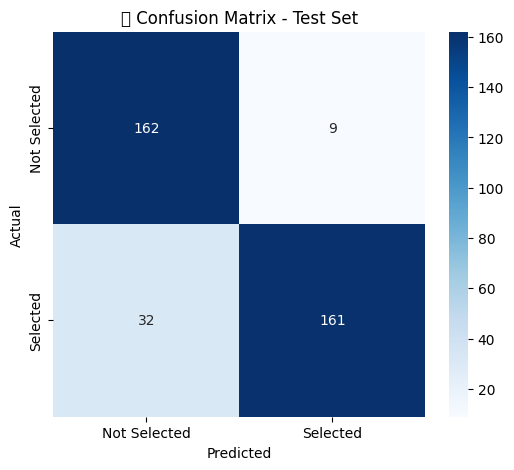

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Selected", "Selected"], yticklabels=["Not Selected", "Selected"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧠 Confusion Matrix - Test Set")
plt.show()

In [ ]:
# Save only the model weights
os.chdir(dataset_path)
torch.save(model.state_dict(), "internship_selection_model.pt")
print("✅ Model weights saved as 'internship_selection_model.pt'")


✅ Model weights saved as 'internship_selection_model.pt'


In [ ]:
# Re-initialize the same model architecture
os.chdir(dataset_path)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.load_state_dict(torch.load("internship_selection_model.pt", map_location=torch.device('cpu')))
model.to('cpu')
model.eval()
print("✅ Model loaded from 'internship_selection_model.pt'")


✅ Model loaded from 'internship_selection_model.pt'


### Testing

In [ ]:


# sample_1 = {
#     'town': 'Bay Roberts',
#     'identify_as': 'Indiginious',
#     'specify_below': ' ',
#     "why_internship": " ",
#     "tech_experience": "Just basic HTML and YouTube tutorials.",
#     "non_tech_experience": "Volunteered in community projects, strong in communication.",
#     "goals": "Learn from mentors and understand what a tech career looks like.",
#     "other_comments": "Really eager to learn even if I'm unsure right now."
# }


In [ ]:
sample_2 = {
    'town': 'St. Johns',
    'identify_as': 'Male',
    'specify_below': ' ',
    "why_internship": "I have an interest in tech and hope to have a tech profession in the future. This opportunity will help me solidify that dream.",
    "tech_experience": "I am able to research online, use Google Sheets, and word for school work. I am also play games on PlayStation.",
    "non_tech_experience": "I am a dedicated volunteer in my community. I come from a larger size family where team work makes the dream work where I am the second eldest so a lot of responsibilities fall onto me. I have played on many all star soccer teams and school teams all throughout my time in school and I am personable and approachable and eager to learn.",
    "goals": "I will be attending MUN in September for engineering.",
    "other_comments": "I am excited for this opportunity."
}


In [ ]:
# Define the full list of fields you want to clean
fields_to_clean = [
    'town', 'identify_as', 'specify_below',
    'why_internship', 'tech_experience', 'non_tech_experience', 'goals', 'other_comments'
]

# Clean all selected fields in the sample
cleaned_sample = {
    key: clean_and_lemmatize(value) if key in fields_to_clean else value
    for key, value in sample_2.items()
}

# Combine all fields into one text string for the model
def combine_fields(entry):
    return " ".join([entry.get(col, "") for col in fields_to_clean])

test_samples = [combine_fields(cleaned_sample)]

# Tokenize and move to device
inputs = tokenizer(test_samples, return_tensors="pt", padding=True, truncation=True, max_length=256)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run model prediction
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1)

# Display result
for i, raw_text in enumerate(test_samples):
    label = "✅ SELECTED" if preds[i].item() == 1 else "❌ NOT SELECTED"
    confidence = probs[i][preds[i]].item()
    print(f"\n➡️ Prediction: {label} (Confidence: {confidence:.2f})\n")



➡️ Prediction: ❌ NOT SELECTED (Confidence: 0.89)

